In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn-darkgrid')
import random

mpl.rcParams.update({'font.size': 14})
# mpl.rcParams["font.size"] = 18

from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import classification_report, f1_score
# stats
from scipy import stats, optimize
import pymc3 as pm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Loading data and simple EDA

In [3]:
df = pd.read_csv('data/voice.csv')
pd.set_option('display.max_columns', None)

## all features in my dataset
meanfreq: mean frequency (in kHz)

sd: standard deviation of frequency

median: median frequency (in kHz)

Q25: first quantile (in kHz)

Q75: third quantile (in kHz)

IQR: interquantile range (in kHz)

skew: skewness (see note in specprop description)

kurt: kurtosis (see note in specprop description)

sp.ent: spectral entropy

sfm: spectral flatness

mode: mode frequency

centroid: frequency centroid (see specprop)

peakf: peak frequency (frequency with highest energy)

meanfun: average of fundamental frequency measured across acoustic signal

minfun: minimum fundamental frequency measured across acoustic signal

maxfun: maximum fundamental frequency measured across acoustic signal

meandom: average of dominant frequency measured across acoustic signal

mindom: minimum of dominant frequency measured across acoustic signal

maxdom: maximum of dominant frequency measured across acoustic signal

dfrange: range of dominant frequency measured across acoustic signal

modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of 

fundamental frequencies divided by the frequency range

label: male or female

In [4]:
# no missing values
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

In [20]:
# dummy for gender
sex = pd.get_dummies(df['label'],drop_first=True)
df = pd.concat([df, sex], axis=1)
df.drop('label',axis=1,inplace=True)

In [5]:
df.shape

(3168, 21)

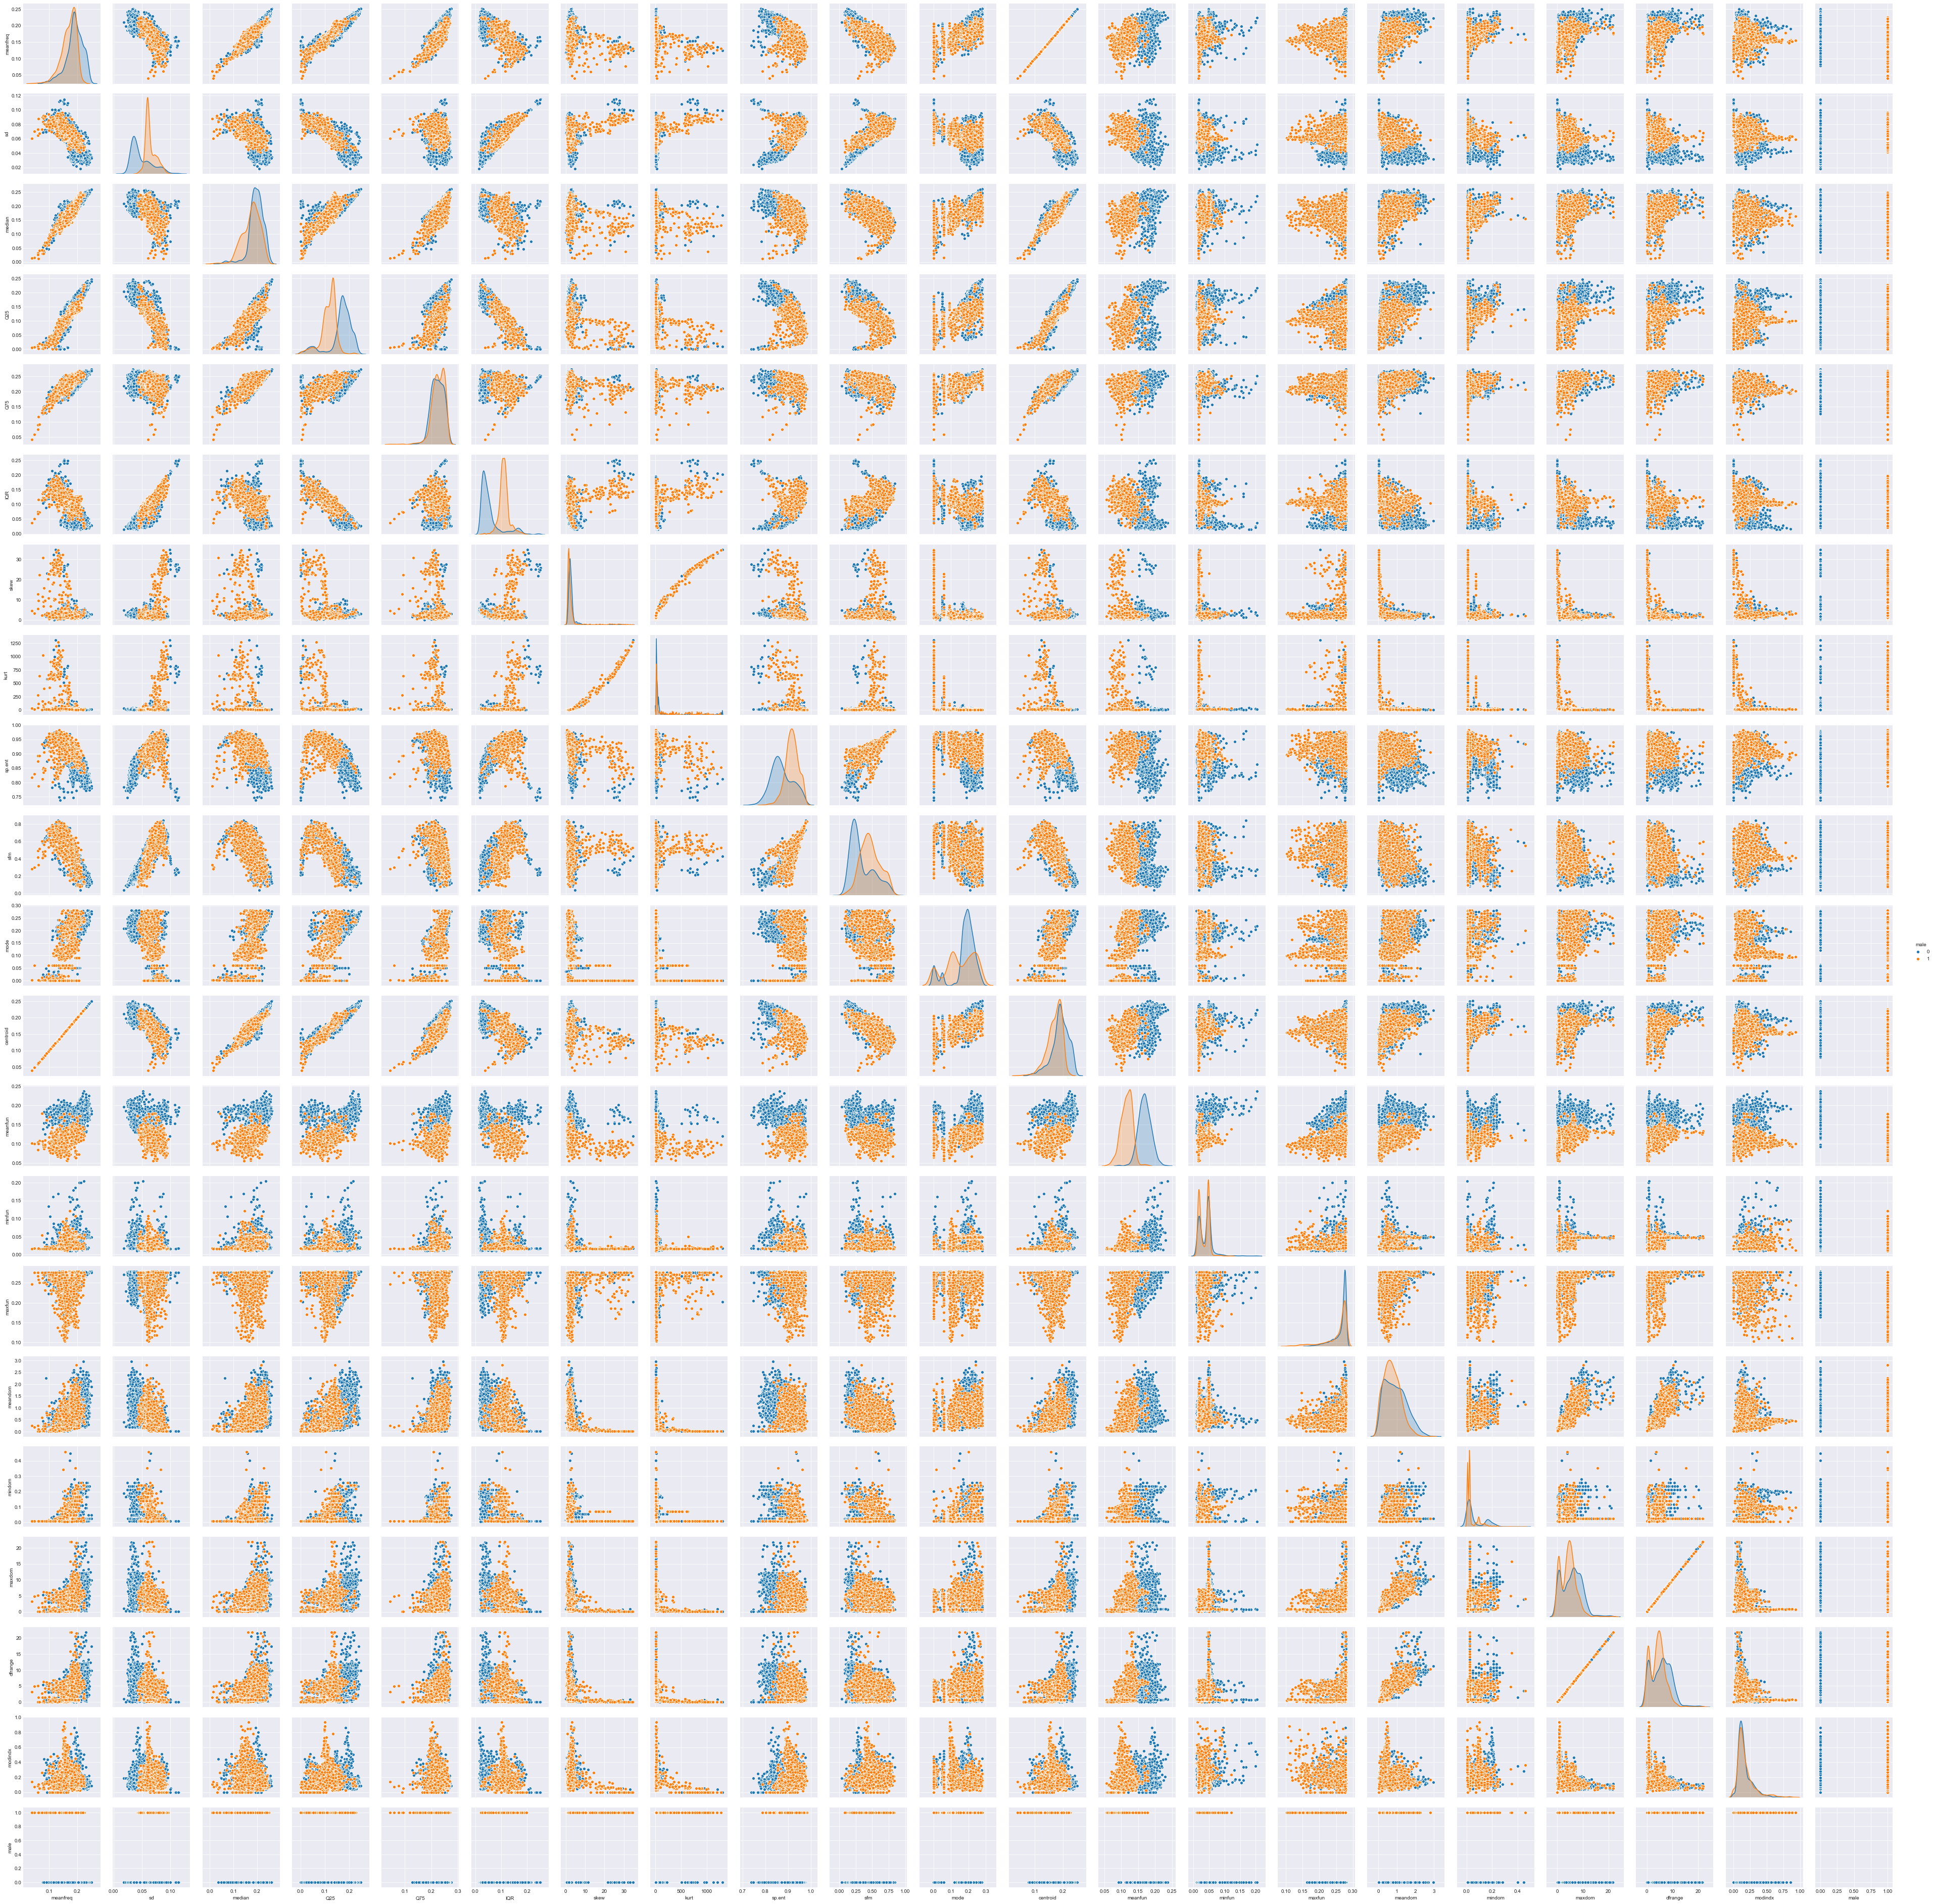

In [22]:
# pairplot for all features
sns.pairplot(df,hue='male')
plt.savefig("pairplot.png")

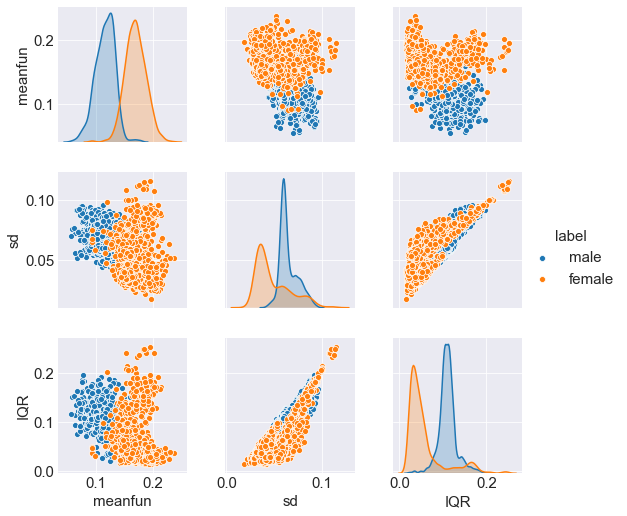

In [18]:
# change the font size
mpl.rcParams.update({'font.size': 15})
# do pairplot before dummy variables
sns.pairplot(df[['meanfun','sd','IQR','label']], hue='label' )
plt.savefig("pairplot1.jpg")

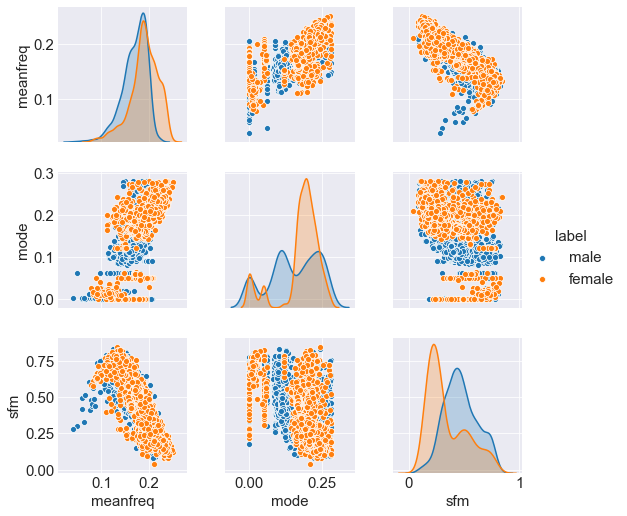

In [19]:
mpl.rcParams.update({'font.size': 15})
sns.pairplot(df[['meanfreq','mode','sfm','label']], hue='label' )
plt.savefig("pairplot2.jpg")

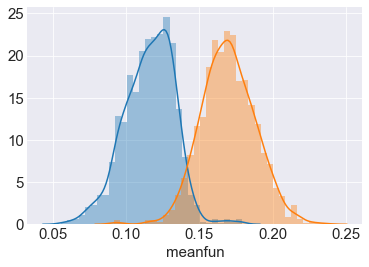

In [21]:
mpl.rcParams.update({'font.size': 15})
# meanfun seems to be the most relevant feature
sns.distplot(df[ df['male']==1]['meanfun']) 
sns.distplot(df[ df['male']==0]['meanfun'])

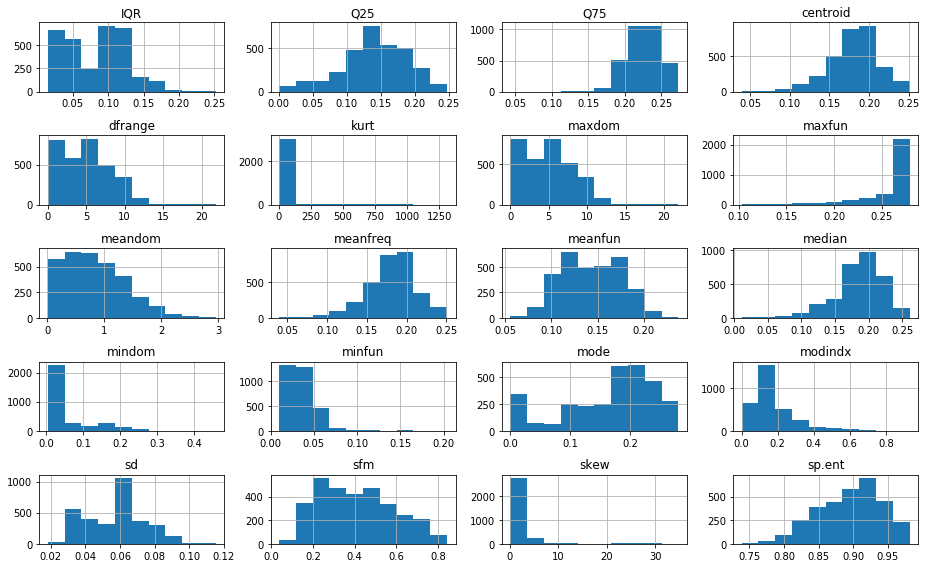

In [41]:
# histplot of all features
df.hist(figsize=(13,8))
plt.tight_layout()

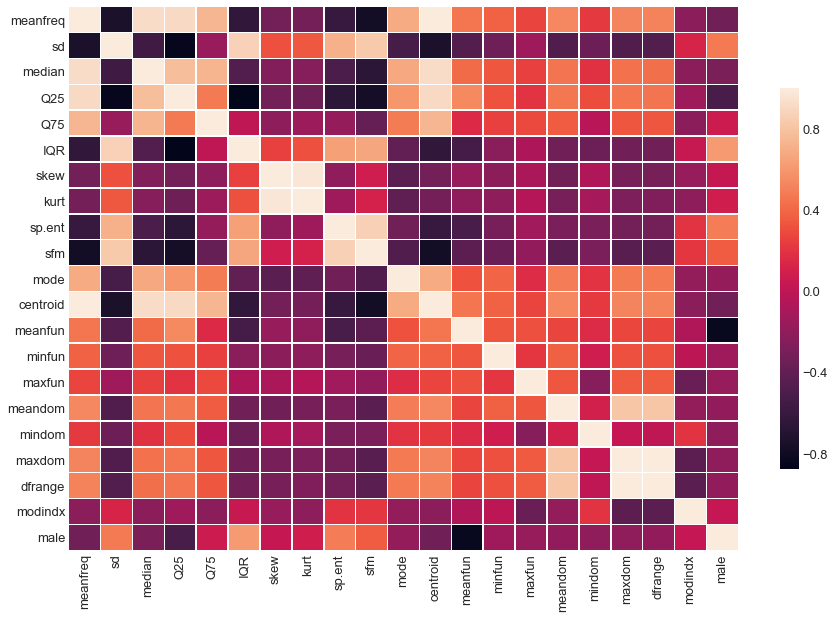

In [41]:
# correlation coefficients
mpl.rcParams.update({'font.size': 13})
# mask for showing only half of the heatmap. Need to add mask=mask in sns.heatmap
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), linewidths=.5, annot = False, cbar_kws={"shrink": .7})
plt.savefig("heatmap.jpg")

In [227]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'male'],
      dtype='object')

## VIF !

In [39]:
def vifs(x):
    '''
    Input x as a DataFrame, calculates the vifs for each variable in the DataFrame.
    DataFrame should not have response variable. 
    Returns dictionary where key is column name and value is the vif for that column.
    Requires scipy.stats be imported as scs
    '''
    vifs = []
    for index in range(x.shape[1]):
        vifs.append(round(variance_inflation_factor(x.values, index),2))
    return vifs

In [360]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'male'],
      dtype='object')

In [40]:
vifs(df[['sd', 'Q25', 'IQR', 'meanfun', 'sp.ent']])

[72.15, 40.6, 27.99, 27.77, 149.78]

# some important functions

## k-fold cross validation to find the best average of AUC

In [45]:
def kfold_auc(X, y, split):
    
    kfold = KFold(n_splits=split)
    
    aucs = []

    for train_index, test_index in kfold.split(X):
        model = LogisticRegression() # create instance
        model.fit(X[train_index], y[train_index]) # training
    
        probabilities = model.predict_proba(X[test_index])[:, 1]
        y_true = y[test_index]
        
        acc, recall, precision, f1, fpr, thresholds = all_metrics(probabilities, y_true)
    
        aucs.append(metrics.auc(fpr, recall))

    print("Averge of area under curve is:", np.average(aucs))

## plots ROC curve

In [69]:
def plot_roc(X_train, X_test, y_train, y_test, name):
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]

    acc, recall, precision, f1, fpr, thresholds = all_metrics(probabilities, y_test)
    
    mpl.rcParams.update({'font.size': 15})
    plt.figure(figsize = (10,6))
    plt.plot(fpr, recall)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title(name)
    plt.savefig('{}.jpg'.format(name)) # save fig

## f1_score, accuracy, recall and precision versus threshold

In [47]:
# different threshold
def all_metrics(probabilities, labels):
    
    thresholds = np.sort(probabilities)

    f1 = []
    acc = []
    recall = []
    precision = []
    fpr = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # boolean
        predicted_positive = probabilities >= threshold
        predicted_negative = probabilities < threshold
        # tp, tn, fp, fn
        true_positives = np.sum(predicted_positive * labels)
        true_negatives = np.sum(predicted_negative * (1-labels))
        false_positives = np.sum(predicted_positive) - true_positives
        false_negatives = np.sum(predicted_negative) - true_negatives
        # metrics        
        f1_score = 2*true_positives / (2*true_positives + false_positives + false_negatives)
        accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        recalls = true_positives / (true_positives + false_negatives)
        precisions = true_positives / (true_positives + false_positives)
        fprs = false_positives / (false_positives + true_negatives)
        # append to lists
        recall.append(recalls)
        precision.append(precisions)
        f1.append(f1_score)
        acc.append(accuracy)
        fpr.append(fprs)

    return acc, recall, precision, f1, fpr, thresholds.tolist() # nparray.tolist() converting nparray into list

## plot metrics vs thresholds (find the best threshold)

In [70]:
def plot_metrics(X_train, X_test, y_train, y_test, vertical, x_lower, x_upper, y_lower, y_upper):
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]

    acc, recall, precision, f1, fpr, thresholds = all_metrics(probabilities, y_test)
    
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    
#     ax[0].plot(thresholds, f1)
    
#     ax[0].set_xlabel("Threshold")
#     ax[0].set_ylabel("F1_score")
#     ax[0].set_title("Find the best threshold")
    
    mpl.rcParams.update({'font.size': 15})
    ax.plot(thresholds, acc, label='accuracy')
    ax.plot(thresholds, recall, label='recall')
    ax.plot(thresholds, precision, label='precision')
    ax.plot(thresholds, f1, label='f1_score')
    ax.axvline(x=vertical, linestyle='dashed')
    ax.set_xlabel("threshold")
    ax.set_ylabel("metrics")
    ax.set_title("Trend of all metrics")
    ax.set_xlim(x_lower, x_upper)
    ax.set_ylim(y_lower, y_upper)
    ax.legend()
    plt.savefig('trend.jpg')
    

## plots confusion matrix

In [82]:
def plot_confusion_matrix(X_train, X_test, y_train, y_test, threshold):  
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1]
    
    prob = np.array(probabilities).copy()
    prob[ prob >= threshold ] = 1
    prob[ prob < threshold ] = 0
    corr = confusion_matrix(y_test, prob)
    plt.figure(figsize = (10,8))
    mpl.rcParams.update({'font.size': 15})
    sns.heatmap(corr, cmap='YlGnBu',annot=True,fmt='g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.jpg')

## printout metrics for the best threshold

In [50]:
def print_metrics(X_train, X_test, y_train, y_test, threshold):
    
    # train model to get prediction
    model = LogisticRegression()
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)[:, 1] 
    labels = y_test
    # boolean    
    predicted_positive = probabilities >= threshold
    predicted_negative = probabilities < threshold
    # tp,tn,fp,fn
    true_positives = np.sum(predicted_positive * labels)
    true_negatives = np.sum(predicted_negative * (1-labels))
    false_positives = np.sum(predicted_positive) - true_positives
    false_negatives = np.sum(predicted_negative) - true_negatives
    # metrics
    f1_score = 2*true_positives / (2*true_positives + false_positives + false_negatives)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    recalls = true_positives / (true_positives + false_negatives)
    precisions = true_positives / (true_positives + false_positives)
    # printout
    print('Accuracy is:', accuracy)
    print('Precision is:', precisions)
    print('Recall is:', recalls)
    print('F1_score is:', f1_score)

## sigmoid function from statsmodel and sklearn

In [122]:
def plot_sigmoid(X_train, X_test, y_train, y_test, x_lower=0.05, x_upper=0.25):
    
    X_const = add_constant(X_train, prepend=True)
    stats_model = Logit(y_train, X_const).fit()
    
    sklearn = LogisticRegression()
    sklearn.fit(X_train, y_train)
    y = sklearn.predict_proba(X_test)[:,1]
    #y = 1/(1 + np.exp(-X_test * sklearn.coef_ - sklearn.intercept_) )

    mpl.rcParams.update({'font.size': 15})
    plt.figure(figsize=(10,8))
    plt.scatter(X1_test, y1_test.reshape(-1,1), label='data') # true y
    # statsmodel
    sns.lineplot(X_test.ravel(), 1/(1 + np.exp(-stats_model.params[0] - stats_model.params[1] * X_test.ravel() )), color='red', linewidth=2, label='statsmodel')
    sns.lineplot(X_test.ravel(), y, color='green', linewidth=2, label = 'sklearn')
    plt.xlim(x_lower,x_upper)
    plt.xlabel('mean fundamental frequency')
    plt.ylabel('probability')
    plt.legend()
    plt.savefig('sigmoid.jpg')

## 5 ROC in one plot

In [ ]:
# five-in-one plot
def one_feature_roc(df=df):
    features = ['meanfun', 'IQR', 'sd', 'Q25', 'sp.ent']
    xs = []
    ys = []
    for feature in features:
        X = df[feature].values
        X = X.reshape(-1,1) # annoying dimension issue for single feature
        y = df['male'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        model = LogisticRegression()
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_test)[:, 1]

        acc, recall, precision, f1, fpr, thresholds = all_metrics(probabilities, y_test)
        
        xs.append(fpr)
        ys.append(recall)
    
        
    mpl.rcParams.update({'font.size': 15})
    plt.figure(figsize = (10,8))
    plt.plot(xs[0],xs[0],linestyle='--')
    for i in range(5):
        plt.plot(xs[i], ys[i],label=features[i])
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.title('ROC of 5 one-feature models')
    plt.legend()
    plt.savefig('five_feature.jpg')

# 2. Single feature: mean fundamental frequency

## statsmodel summary

In [143]:
X1 = df['meanfun'].values
X1 = X1.reshape(-1,1) # annoying dimension issue for single feature
y1 = df['male'].values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3)
X1_const = add_constant(X1_train, prepend=True)
logit_model = Logit(y1_train, X1_const).fit() # logistic training
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2217
Model:                          Logit   Df Residuals:                     2215
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Feb 2019   Pseudo R-squ.:                     inf
Time:                        00:40:01   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5338      1.418     19.417      0.000      24.754      30.313
x1          -195.3612     10.126  

## 5-fold cross validation training

In [90]:
kfold_auc(X1_train,y1_train,split=5)

Averge of area under curve is: 0.86902671193365


## ROC curves

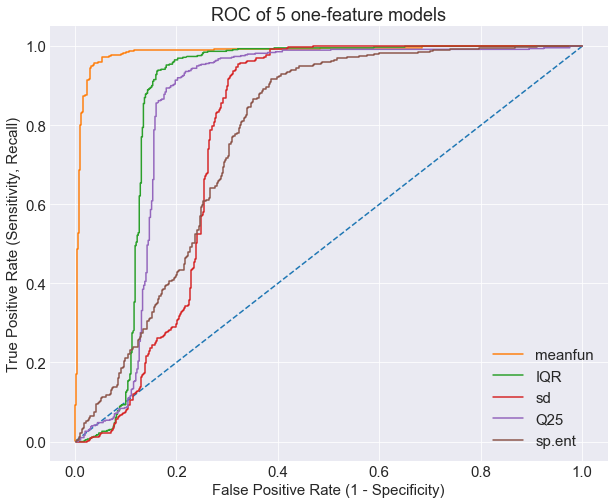

In [68]:
one_feature_roc(df=df)

# finding the best threshold

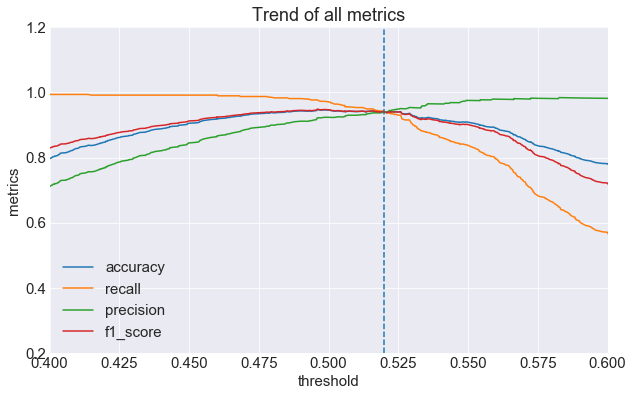

In [74]:
plot_metrics(X1_train, X1_test, y1_train, y1_test,0.52,0.4,0.6,0.2,1.2)

## confusion matrix and metrics

Accuracy is: 0.9400630914826499
Precision is: 0.9388185654008439
Recall is: 0.9408033826638478
F1_score is: 0.9398099260823654


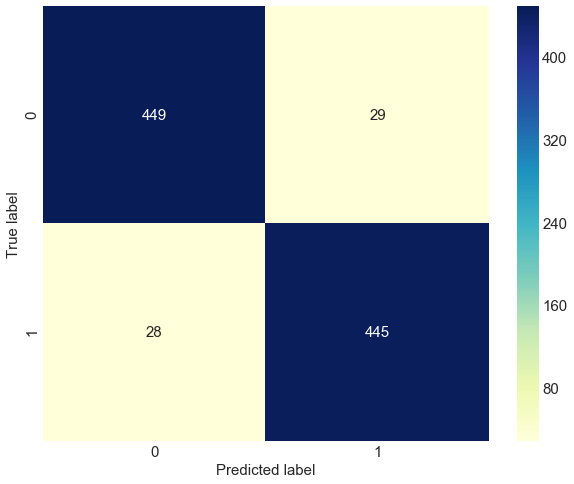

In [83]:
plot_confusion_matrix(X1_train, X1_test, y1_train, y1_test, threshold=0.52)
print_metrics(X1_train, X1_test, y1_train, y1_test, threshold=0.52)

## standardize

In [77]:
X1_train_scaled = preprocessing.scale(X1_train)
X1_test_scaled = preprocessing.scale(X1_test)

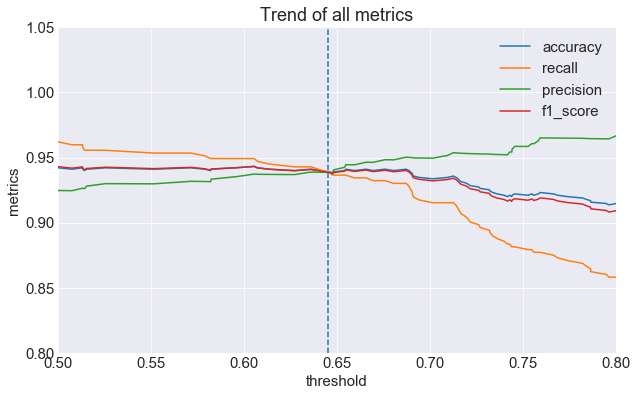

In [81]:
plot_metrics(X1_train_scaled, X1_test_scaled, y1_train, y1_test, 0.645, 0.5, 0.8, 0.8, 1.05)

In [247]:
print_metrics(X1_train_scaled, X1_test_scaled, y1_train, y1_test, threshold=0.64)

Accuracy is: 0.9474237644584648
Precision is: 0.946236559139785
Recall is: 0.946236559139785
F1_score is: 0.946236559139785


## sigmoid function

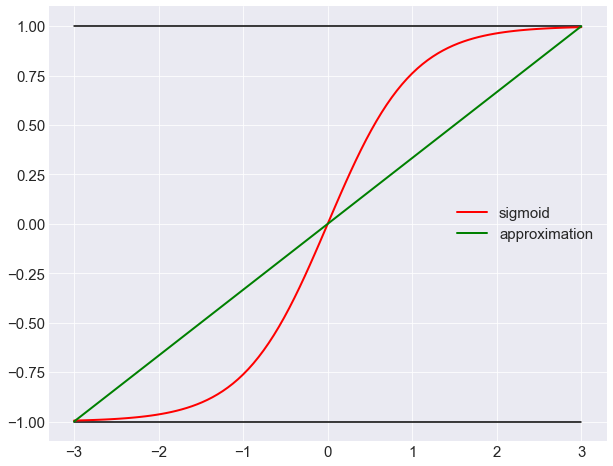

In [125]:
plt.figure(figsize=(10,8))
x = np.linspace(-3,3,100)
sns.lineplot(x,y=1,color='black')
sns.lineplot(x,y=-1,color='black')
sns.lineplot(x, 2/(1 + np.exp(-2*x))-1, color='red', linewidth=2, label='sigmoid')
sns.lineplot(x, x/3, color='green', linewidth=2, label = 'approximation')
plt.ylim(-1.1,1.1)
# plt.xlabel('mean fundamental frequency')
# plt.ylabel('probability')
plt.legend()
plt.savefig('approx.jpg')

Optimization terminated successfully.
         Current function value: inf
         Iterations 9


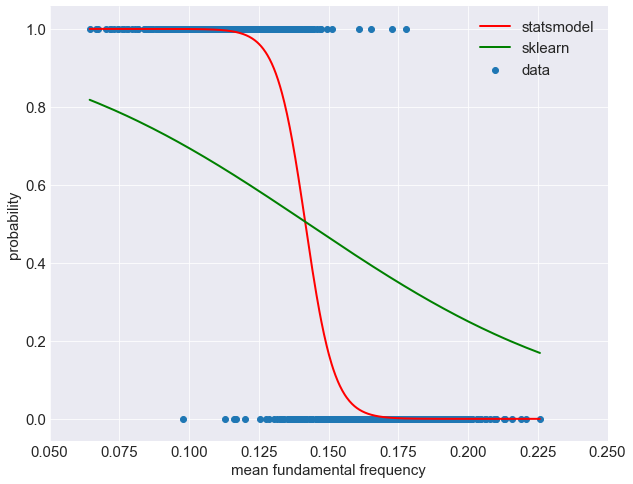

In [123]:
plot_sigmoid(X1_train, X1_test, y1_train, y1_test, x_lower=0.05, x_upper=0.25)

## Frequentist A/B test

In [188]:
cols=df.columns
cols=cols.drop('male')
pvalues = []
for col in cols:
    t, p = stats.ttest_ind(df[ df['male']==1][col], df[ df['male']==0][col], equal_var=False)
    pvalues.append([col,np.round(p,5)])

In [189]:
pd.DataFrame(pvalues)
pvalues

[['meanfreq', 0.0],
 ['sd', 0.0],
 ['median', 0.0],
 ['Q25', 0.0],
 ['Q75', 0.00016],
 ['IQR', 0.0],
 ['skew', 0.03928],
 ['kurt', 0.0],
 ['sp.ent', 0.0],
 ['sfm', 0.0],
 ['mode', 0.0],
 ['centroid', 0.0],
 ['meanfun', 0.0],
 ['minfun', 0.0],
 ['maxfun', 0.0],
 ['meandom', 0.0],
 ['mindom', 0.0],
 ['maxdom', 0.0],
 ['dfrange', 0.0],
 ['modindx', 0.08303]]

## Bayesian A/B test

In [218]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'male'],
      dtype='object')

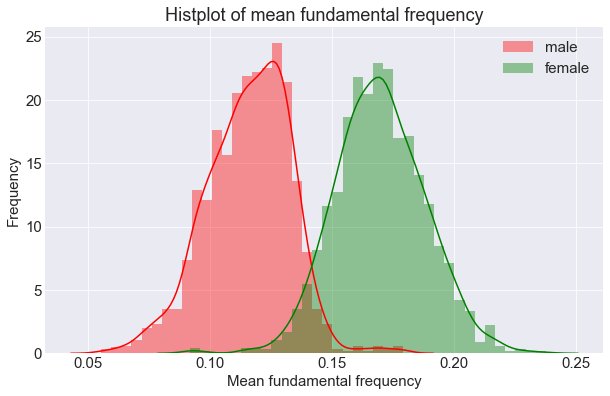

In [42]:
# meanfun seems to be the most relevant feature
mpl.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,6))
sns.distplot(df[ df['male']==1]['meanfun'],color='red',label='male') 
sns.distplot(df[ df['male']==0]['meanfun'],color='green', label='female')
plt.xlabel('Mean fundamental frequency')
plt.ylabel('Frequency')
plt.title('Histplot of mean fundamental frequency')
plt.legend()
plt.savefig('ab_test.jpg')


In [238]:
# a and b are columns from dataframes
def bayesian_ab(a, b, num):
    male = a.sample(num).values
    female = b.sample(num).values
    prob = (female > male).mean() * 100
    print('There is a {:.2f}% probability that mean fundamental frequency of female is higher than male \n'.format(prob))

In [239]:
bayesian_ab(df[ df['male']==1]['meanfun'], df[ df['male']==0]['meanfun'], 1000)

There is a 98.90% probability that mean fundamental frequency of female is higher than male 



# 3. Discard mean of fundamental frequency

## sort out less relevant features

In [63]:
def one_feature_plot(df):
    cols=df.columns
    cols=cols.drop('male')
    for col in cols:
        X = df[col].values
        X = X.reshape(-1,1)
        y = df['male'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        plot_roc(X_train, X_test, y_train, y_test, col)
        

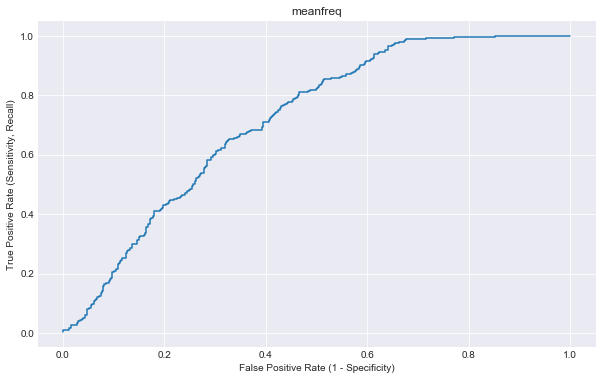

<Figure size 432x288 with 0 Axes>

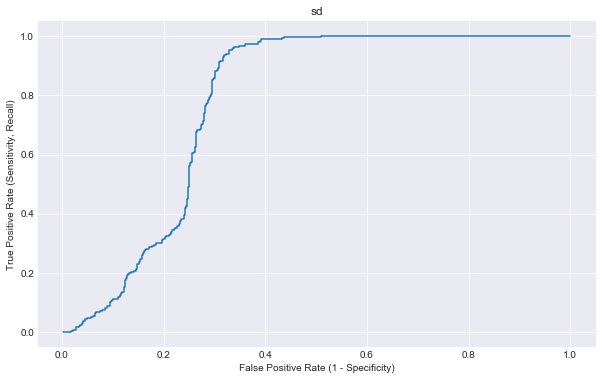

<Figure size 432x288 with 0 Axes>

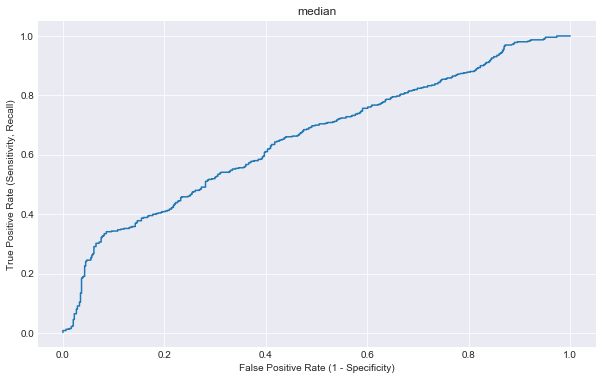

<Figure size 432x288 with 0 Axes>

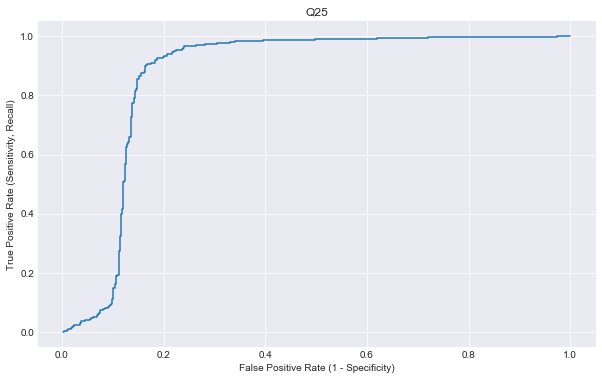

<Figure size 432x288 with 0 Axes>

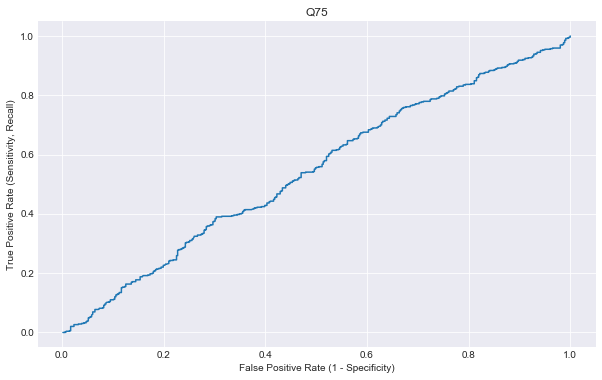

<Figure size 432x288 with 0 Axes>

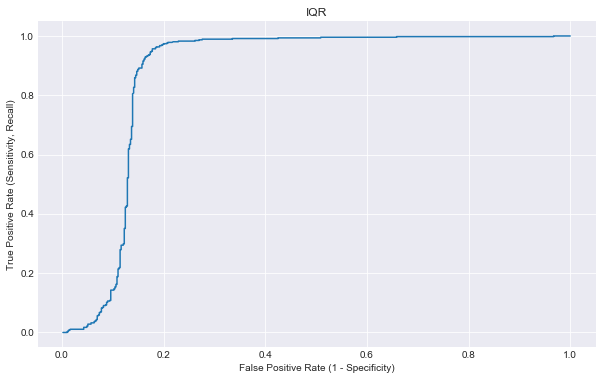

<Figure size 432x288 with 0 Axes>

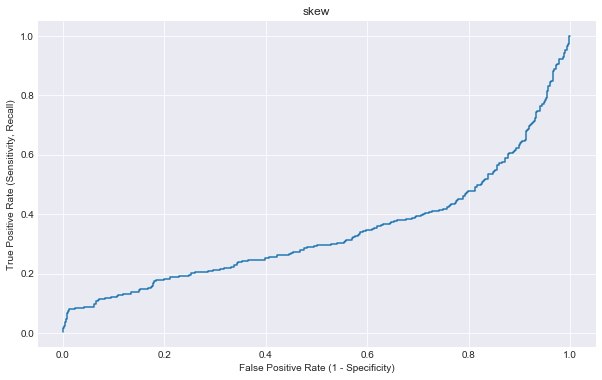

<Figure size 432x288 with 0 Axes>

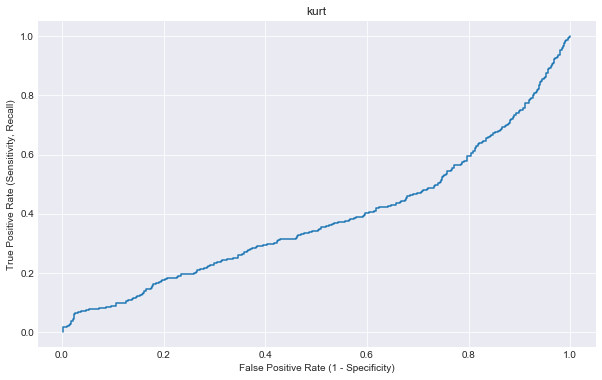

<Figure size 432x288 with 0 Axes>

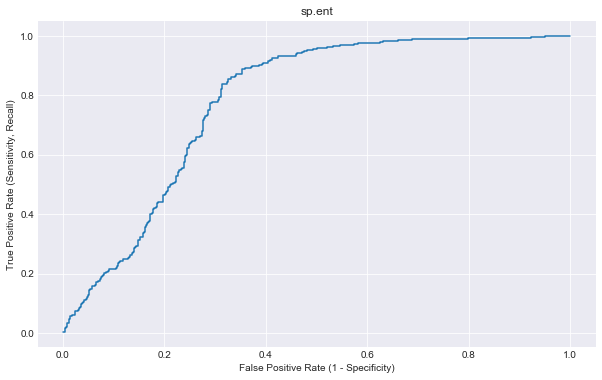

<Figure size 432x288 with 0 Axes>

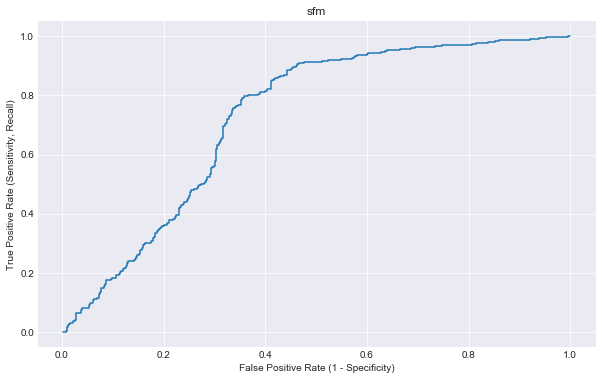

<Figure size 432x288 with 0 Axes>

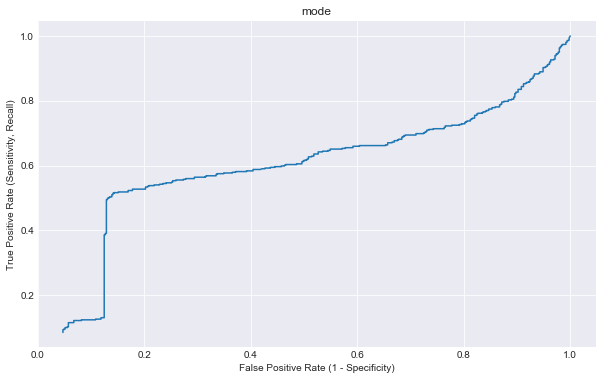

<Figure size 432x288 with 0 Axes>

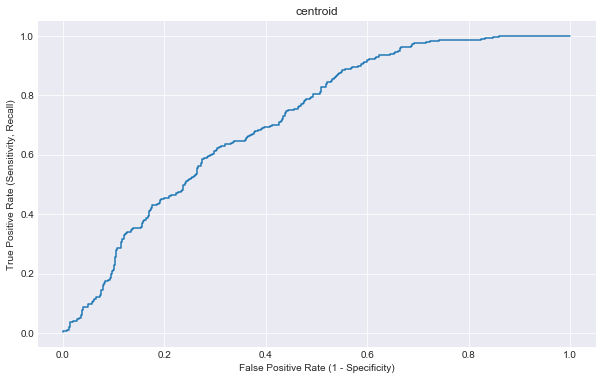

<Figure size 432x288 with 0 Axes>

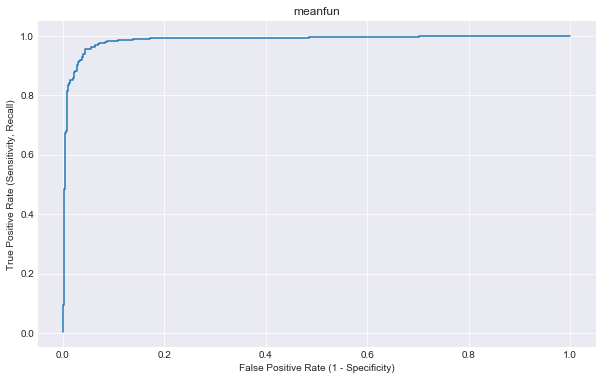

<Figure size 432x288 with 0 Axes>

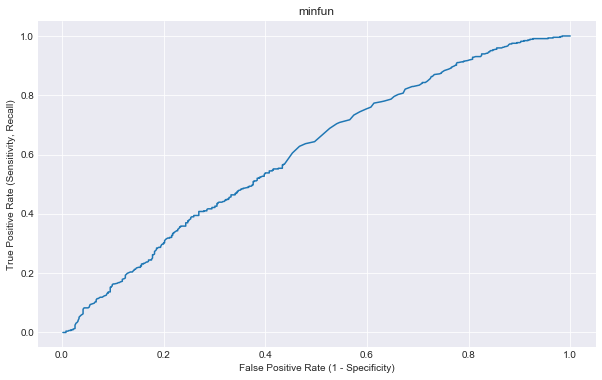

<Figure size 432x288 with 0 Axes>

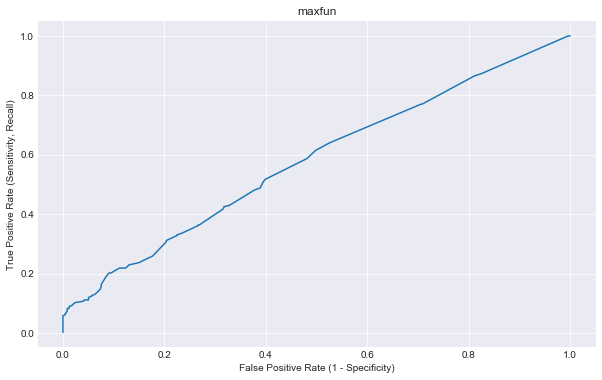

<Figure size 432x288 with 0 Axes>

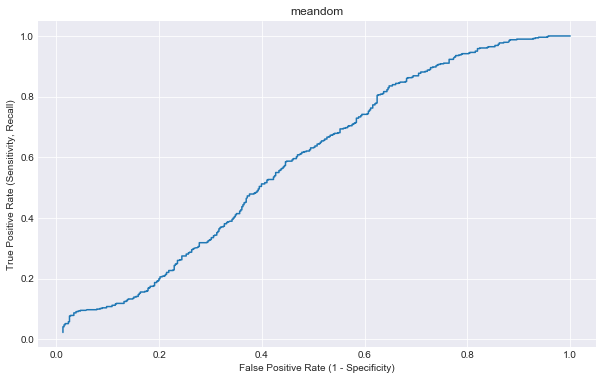

<Figure size 432x288 with 0 Axes>

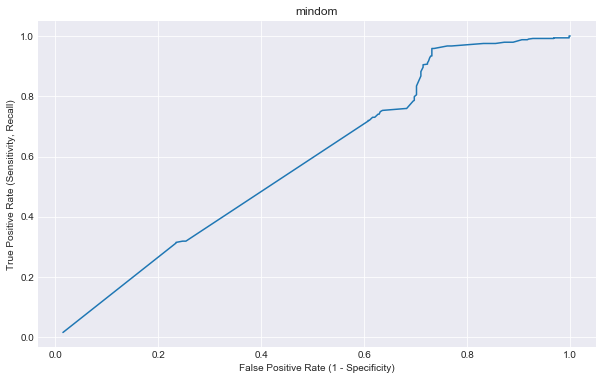

<Figure size 432x288 with 0 Axes>

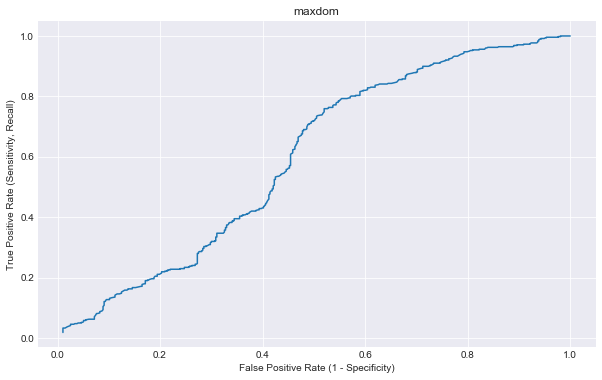

<Figure size 432x288 with 0 Axes>

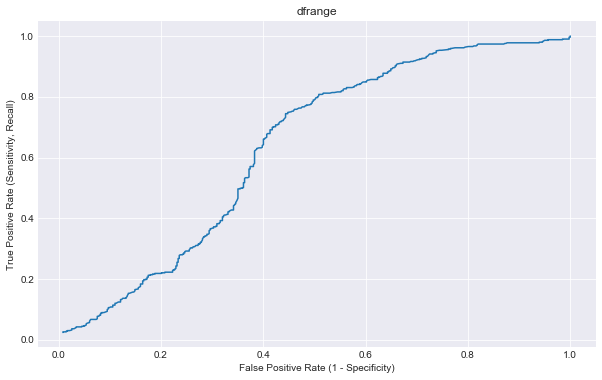

<Figure size 432x288 with 0 Axes>

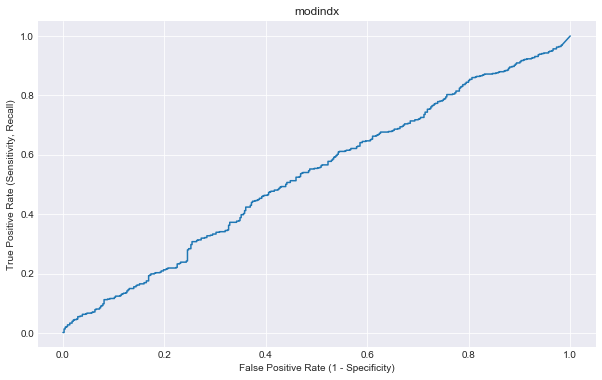

<Figure size 432x288 with 0 Axes>

In [64]:
one_feature_plot(df)

In [13]:
X2 = df[['sd', 'Q25', 'IQR', 'sp.ent']].values
y2 = df['male'].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3)
X2_const = add_constant(X2, prepend=True)
logit_model = Logit(y2, X2_const).fit() # logistic training
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3168
Model:                          Logit   Df Residuals:                     3163
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Feb 2019   Pseudo R-squ.:                     inf
Time:                        15:19:32   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.2677      1.506    -13.454      0.000     -23.220     -17.315
x1           -87.6923      7.870  

In [194]:
kfold_auc(X2_train,y2_train,split=5)

Averge of area under curve is: 0.86677979273883


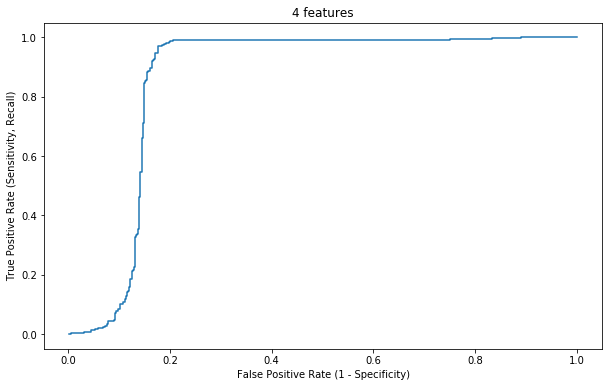

In [196]:
plot_roc(X2_train, X2_test, y2_train, y2_test, '4 features')

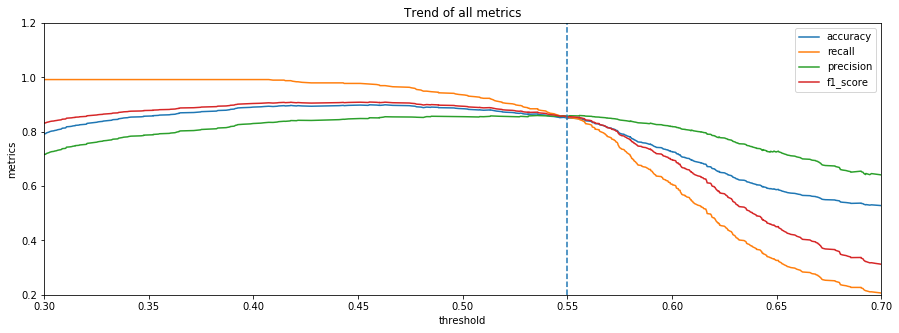

In [248]:
plot_metrics(X2_train, X2_test, y2_train, y2_test,0.55,0.3,0.7,0.2,1.2)

Accuracy is: 0.8717139852786541
Precision is: 0.8560460652591171
Recall is: 0.9046653144016227
F1_score is: 0.8796844181459567


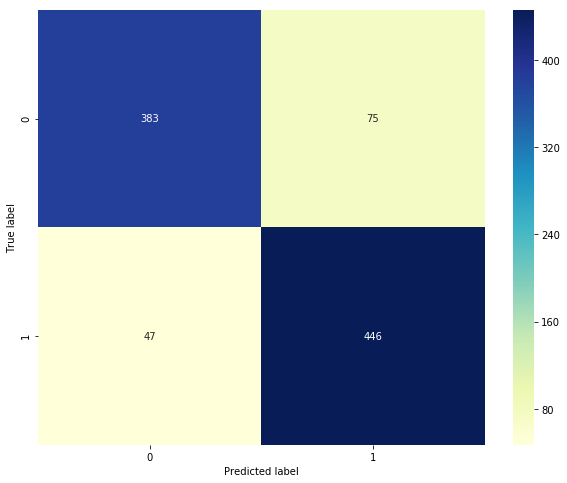

In [200]:
plot_confusion_matrix(X2_train, X2_test, y2_train, y2_test, threshold=0.52)
print_metrics(X2_train, X2_test, y2_train, y2_test, threshold=0.52)

# 4. One feature again: IQR

In [14]:
X3 = df[['IQR']].values
y3 = df['male'].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)
X3_const = add_constant(X3, prepend=True)
logit_model = Logit(y3, X3_const).fit() # logistic training
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3168
Model:                          Logit   Df Residuals:                     3166
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Feb 2019   Pseudo R-squ.:                     inf
Time:                        15:19:37   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5250      0.128    -27.470      0.000      -3.777      -3.273
x1            41.9600      1.404  

In [209]:
kfold_auc(X3_train,y3_train,split=5)

Averge of area under curve is: 0.8722187929643859


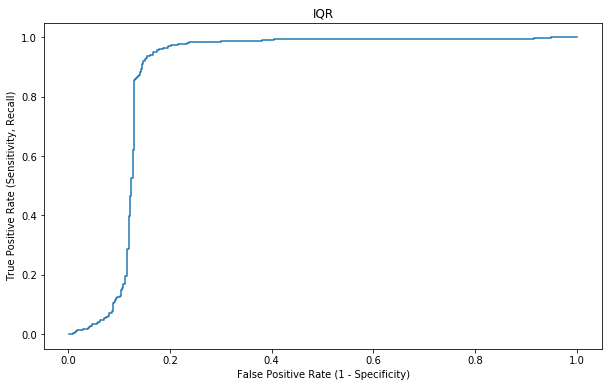

In [211]:
plot_roc(X3_train, X3_test, y3_train, y3_test, 'IQR')

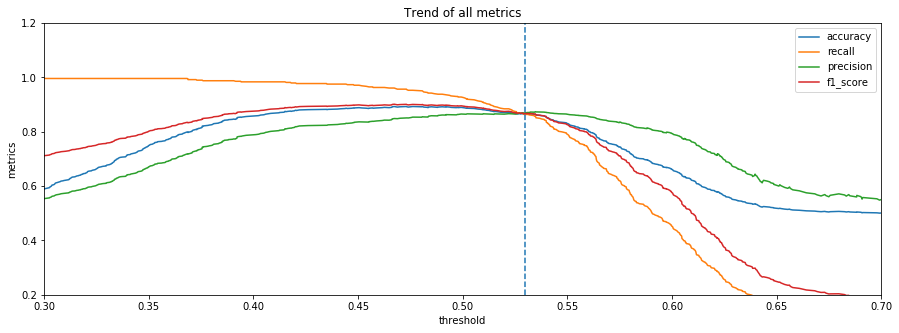

In [249]:
plot_metrics(X3_train, X3_test, y3_train, y3_test,0.53,0.3,0.7,0.2,1.2)

Accuracy is: 0.8717139852786541
Precision is: 0.8663967611336032
Recall is: 0.8842975206611571
F1_score is: 0.8752556237218814


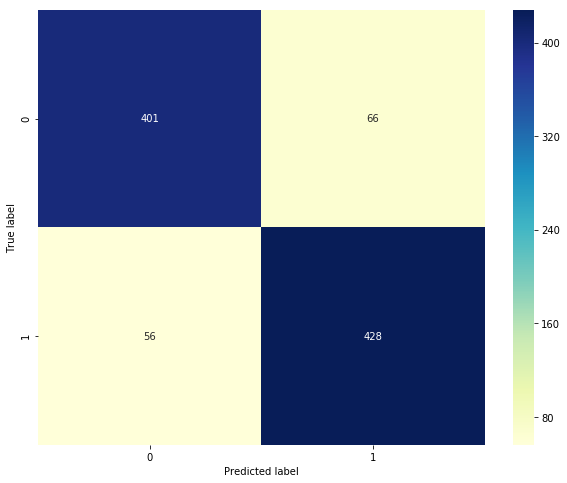

In [215]:
plot_confusion_matrix(X3_train, X3_test, y3_train, y3_test, threshold=0.52)
print_metrics(X3_train, X3_test, y3_train, y3_test, threshold=0.52)

# 4. Gradient descent

## gd functions

In [131]:
def h_func(X, beta):
    return 1/(1 + np.exp(-np.dot(X, beta)))

def cost_log(X, y, beta):
    return -np.dot(y.T, np.log( h_func(X, beta))).sum() - np.dot( (np.ones((1, y.shape[0])) - y.T), np.log(1 - h_func(X, beta))).sum()

def grad_func(X, y, beta):
    return np.dot(X.T, h_func(X, beta) - y.reshape(-1,1) ) 

def cost_log_reg(X, y, beta, lmda):
    return -np.dot(y.T, np.log( h_func(X, beta))).sum() - np.dot( (np.ones((1, y.shape[0])) - y.T), np.log(1 - h_func(X, beta))).sum() + lmda/2 * sum(beta[1:]**2)

def grad_func_reg(X, y, beta, lmda):
    return np.dot(X.T, h_func(X, beta) - y.reshape(-1,1) ) + lmda * sum(beta[1:])

def paramater_update(grad, beta, lr):
    return beta - lr * grad

def logistic_gradient_descent(X, y, beta, lr = .02, max_iter = 300, epsilon = 0.001): 
    i=0
    beta_array = []
    cost_array = []
    while i < max_iter:
        grad = grad_func(X, y, beta) # slop
        cost = cost_log(X, y, beta) # cost
        beta_array.append(beta) # append beta
        cost_array.append(cost) # append cost
        beta = paramater_update(grad, beta, lr) # update beta
        i+=1
    return beta, np.array(beta_array), np.array(cost_array)

def logistic_gradient_descent_reg(X, y, beta, lmda=1, lr = .02, max_iter = 300, epsilon = 0.001): 
    i=0
    beta_array = []
    cost_array = []
    while i < max_iter:
        grad = grad_func_reg(X, y, beta, lmda) # slop
        cost = cost_log_reg(X, y, beta, lmda) # cost
        beta_array.append(beta) # append beta
        cost_array.append(cost) # append cost
        beta = paramater_update(grad, beta, lr) # update beta
        i+=1
#     print(type(beta_array[0]))
    return beta, np.array(beta_array), np.array(cost_array)

def gradient_descent_with_conv(X, y, beta, lr = .02, max_iter = 5000, epsilon = 0.0001):
    cost_array = []
    beta_array = []
    for i in range(max_iter):
        cost_new = cost_log(X, y, beta) # cost
        cost_array.append(cost_new) # append cost
        beta_array.append(beta) # append beta
        if i > 2:
            cost_old = cost_array[-2]
            if abs(cost_old - cost_new)/cost_old < epsilon:
                print('Convergence met at iteration {0}.'.format(i))
                break
        grad = grad_func(X, y, beta)
        beta = paramater_update(grad, beta, lr)
        
    return beta, np.array(beta_array), np.array(cost_array)

def gradient_descent_with_conv_reg(X, y, beta, lmda=1, lr = .02, max_iter = 5000, epsilon = 0.0001):
    cost_array = []
    beta_array = []
    for i in range(max_iter):
        cost_new = cost_log_reg(X, y, beta, lmda) # cost
        cost_array.append(cost_new) # append cost
        beta_array.append(beta) # append beta
        if i > 2:
            cost_old = cost_array[-2]
            if abs(cost_old - cost_new)/cost_old < epsilon:
                print('Convergence met at iteration {0}.'.format(i))
                break
        grad = grad_func_reg(X, y, beta, lmda)
        beta = paramater_update(grad, beta, lr)
        
    return beta, np.array(beta_array), np.array(cost_array)

In [136]:
a, b, c = logistic_gradient_descent_reg(X1_const, y1_train, np.ones((2,1)), lmda= 0, lr=0.01, max_iter = 1000)
a

array([[  16.47237702],
       [-116.00645968]])

In [144]:
a, b, c = gradient_descent_with_conv_reg(X1_const, y1_train, np.ones((2,1)), lmda= 0, lr=0.02, max_iter = 10000, epsilon = 0.0001)
a

Convergence met at iteration 449.


array([[  31.2013975],
       [-221.7452127]])

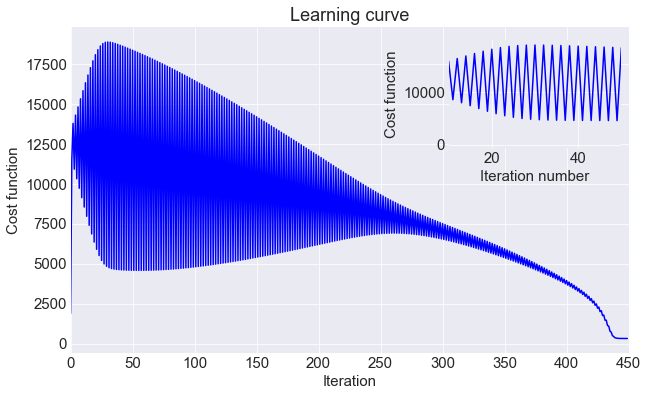

In [148]:
plt.figure(figsize=(10,6))
plt.plot(range(len(c)), c, color='blue')
# plt.plot(range(len(c1)), c1, color='red')
plt.xlabel('Iteration')
plt.ylabel('Cost function')
plt.title('Learning curve')
plt.xlim(0, 450)

a = plt.axes([.65, .6, .24, .25])
plt.plot(range(len(c)), c, color='blue')
# plt.plot(range(len(c1)), c1, color='red')
plt.xlabel('Iteration number')
plt.ylabel('Cost function')
# plt.title('Learning_rate = 0.01, iteration = 500')
plt.xlim(10, 50)

plt.savefig('gradient.jpg')

# Stochastic gradient descent

In [ ]:
def sgd(X, y, lr=0.02, iterations=10000):
    beta_array = []
    cost_array = []
    beta = np.zeros(X.shape[1]) # initialize beta
    #shuffle data X, y = self.shuffle_data_and_response(X, y)
    for i in range(iterations):
        for j in range(X.shape[0]):
            cost = cost_log(X[j, :], y[j], beta) # find cost from updated beta
            cost_history.append(cost) # append cost function
        
            grad = grad_func(X[j, :], y[j], beta) # find grad from initial beta
            beta = paramater_update(grad, beta, lr) # update beta
        # convergent condition    
        has_converged = self.has_converged_stochastic(X.shape[0])
            if (i >= 2 and has_converged):
                print()
                break
        return cost_history

In [ ]:
cost_array = []
    beta_array = []
    for i in range(max_iter):
        cost_new = cost_log(X, y, beta) # cost
        cost_array.append(cost_new) # append cost
        beta_array.append(beta) # append beta
        if i > 2:
            cost_old = cost_array[-2]
            if abs(cost_old - cost_new)/cost_old < epsilon:
                print('Convergence met at iteration {0}.'.format(i))
                break
        grad = grad_func(X, y, beta)
        beta = paramater_update(grad, beta, lr)
        
    return beta, np.array(beta_array), np.array(cost_array)

# 4. Bayesian

In [4]:
df.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm      mode  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  0.000000  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  0.000000  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  0.000000  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  0.083878  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  0.104261  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  male  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000     1  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632     1  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512     1  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119     1  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274     1

In [126]:
with pm.Model() as logistic:
    pm.glm.GLM.from_formula('male ~ meanfun', df, family=pm.glm.families.Binomial())
    start = pm.find_MAP()
    trace = pm.sample(2000,chains=1)
#     step = pm.Slice()
#     trace = pm.sample(niter, start=start, step=step, njobs=4, random_seed=123)

logp = -476.36, ||grad|| = 2.4526: 100%|██████████| 18/18 [00:00<00:00, 787.30it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [meanfun, Intercept]
100%|██████████| 2500/2500 [00:34<00:00, 72.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [127]:
pm.summary(trace)

mean        sd  mc_error     hpd_2.5    hpd_97.5
Intercept   26.538699  1.158979  0.052473   24.336095   28.939966
meanfun   -187.569069  8.226320  0.371476 -205.171795 -172.284603

In [128]:
print(trace)

<MultiTrace: 1 chains, 2000 iterations, 2 variables>


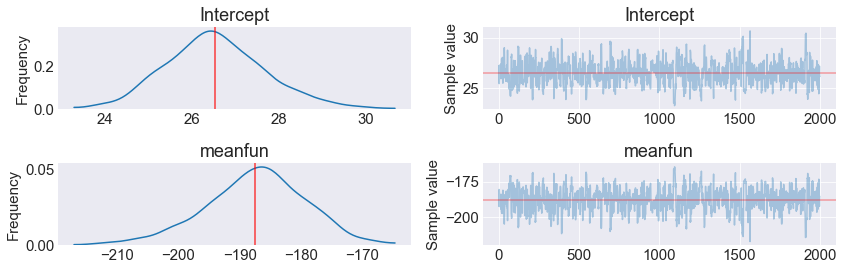

In [130]:
pm.traceplot(trace, varnames=['Intercept', 'meanfun'], lines={'meanfun':-187.569069, 'Intercept':26.538699})
#pm.autocorrplot(trace)
plt.savefig('bayes.jpg')

# 5. Decision tree

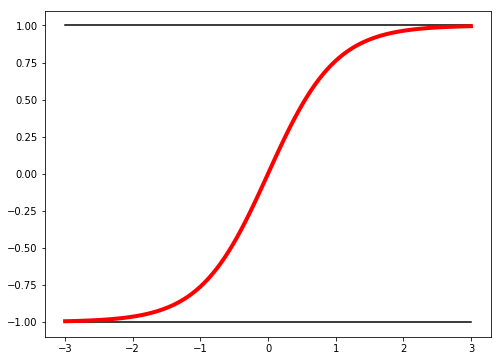

In [2]:
plt.figure(figsize=(8,6))
x = np.linspace(-3,3,100)
sns.lineplot(x,y=1,color='black')
sns.lineplot(x,y=-1,color='black')
sns.lineplot(x, 2/(1 + np.exp(-2*x))-1, color='red', linewidth=4)
plt.ylim(-1.1,1.1)
# plt.xlabel('mean fundamental frequency')
# plt.ylabel('probability')
plt.savefig('nonlinear.jpg')